In [1]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import os
import pandas as pd
import numpy as np
import pyfolio as pf

## Zipline 데이터 위치 설정

In [4]:
from zipline.utils.run_algo import load_extensions

os.environ['ZIPLINE_ROOT'] = 'C:/Users/userpc/.zipline/'
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [5]:
from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars,
    set_long_only,
    symbol,
    set_benchmark,
    sid,
    order_target
)
from zipline import run_algorithm
from zipline.finance import commission, slippage
import zipline.utils.calendar_utils as tc
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
from zipline import run_algorithm

In [43]:
def handle_data(context, data):
    print(f"Date: {context.datetime}")

    context.i += 1
    close = data.current(context.asset, 'close')

    # if context.i == 1:
    #     order_target_percent(context.asset, 1)
    #     print(f"asset name: {context.asset.asset_name}: 가격: {close}")
    #
    if context.i < 300:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=180, frequency="1m").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=600, frequency="1m").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
        context.i = 0
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)
        context.i = 0

def initialize(context):
    context.i = 0
    context.asset = symbol('KRW-SAND')
    context.set_slippage(slippage.VolumeShareSlippage())
    context.set_benchmark(symbol('KRW-SAND'))


start = pd.Timestamp('2021-10-01', tz='utc')
end = pd.Timestamp('2022-02-07', tz='utc')

results = run_algorithm(start=start,
                        end=end,
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=1e6,
                        data_frequency='minute',
                        emission_rate='minute',
                        bundle='upbit',
                        trading_calendar=tc.get_calendar('24/7')
                        )

Date: 2021-10-01 00:00:00+00:00
Date: 2021-10-01 00:01:00+00:00
Date: 2021-10-01 00:02:00+00:00
Date: 2021-10-01 00:03:00+00:00
Date: 2021-10-01 00:04:00+00:00
Date: 2021-10-01 00:05:00+00:00
Date: 2021-10-01 00:06:00+00:00
Date: 2021-10-01 00:07:00+00:00
Date: 2021-10-01 00:08:00+00:00
Date: 2021-10-01 00:09:00+00:00
Date: 2021-10-01 00:10:00+00:00
Date: 2021-10-01 00:11:00+00:00
Date: 2021-10-01 00:12:00+00:00
Date: 2021-10-01 00:13:00+00:00
Date: 2021-10-01 00:14:00+00:00
Date: 2021-10-01 00:15:00+00:00
Date: 2021-10-01 00:16:00+00:00
Date: 2021-10-01 00:17:00+00:00
Date: 2021-10-01 00:18:00+00:00
Date: 2021-10-01 00:19:00+00:00
Date: 2021-10-01 00:20:00+00:00
Date: 2021-10-01 00:21:00+00:00
Date: 2021-10-01 00:22:00+00:00
Date: 2021-10-01 00:23:00+00:00
Date: 2021-10-01 00:24:00+00:00
Date: 2021-10-01 00:25:00+00:00
Date: 2021-10-01 00:26:00+00:00
Date: 2021-10-01 00:27:00+00:00
Date: 2021-10-01 00:28:00+00:00
Date: 2021-10-01 00:29:00+00:00
Date: 2021-10-01 00:30:00+00:00
Date: 20

## Pyfolio 결과 분석

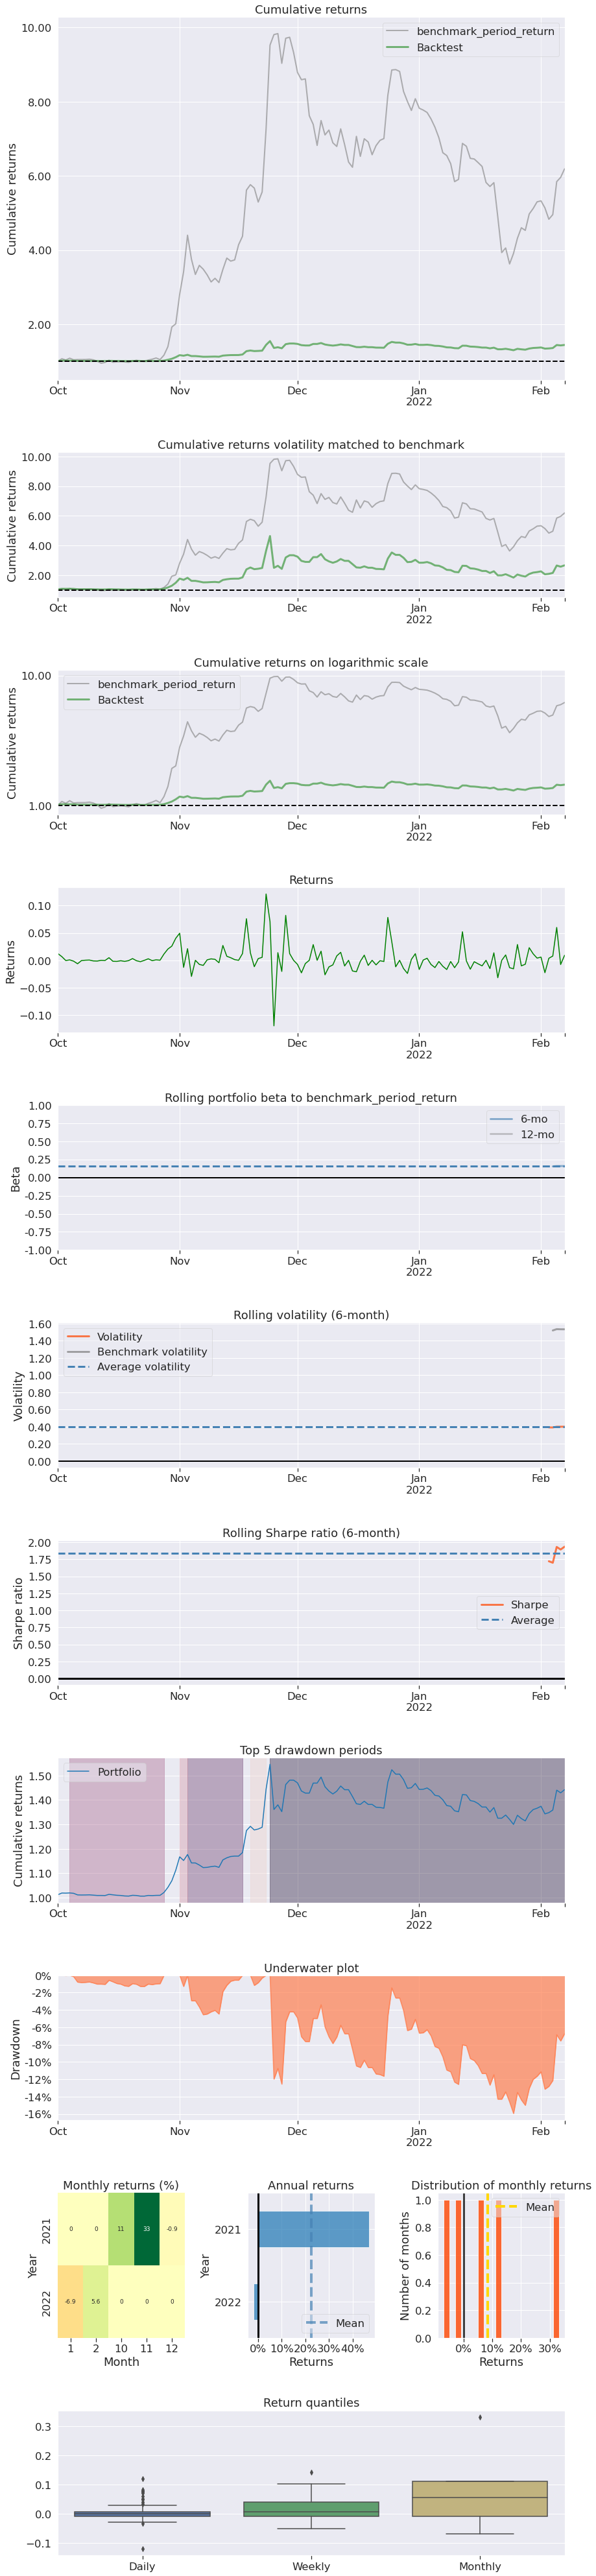

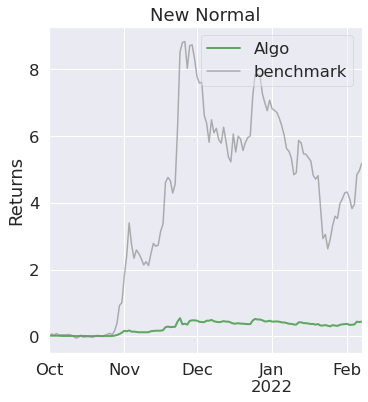

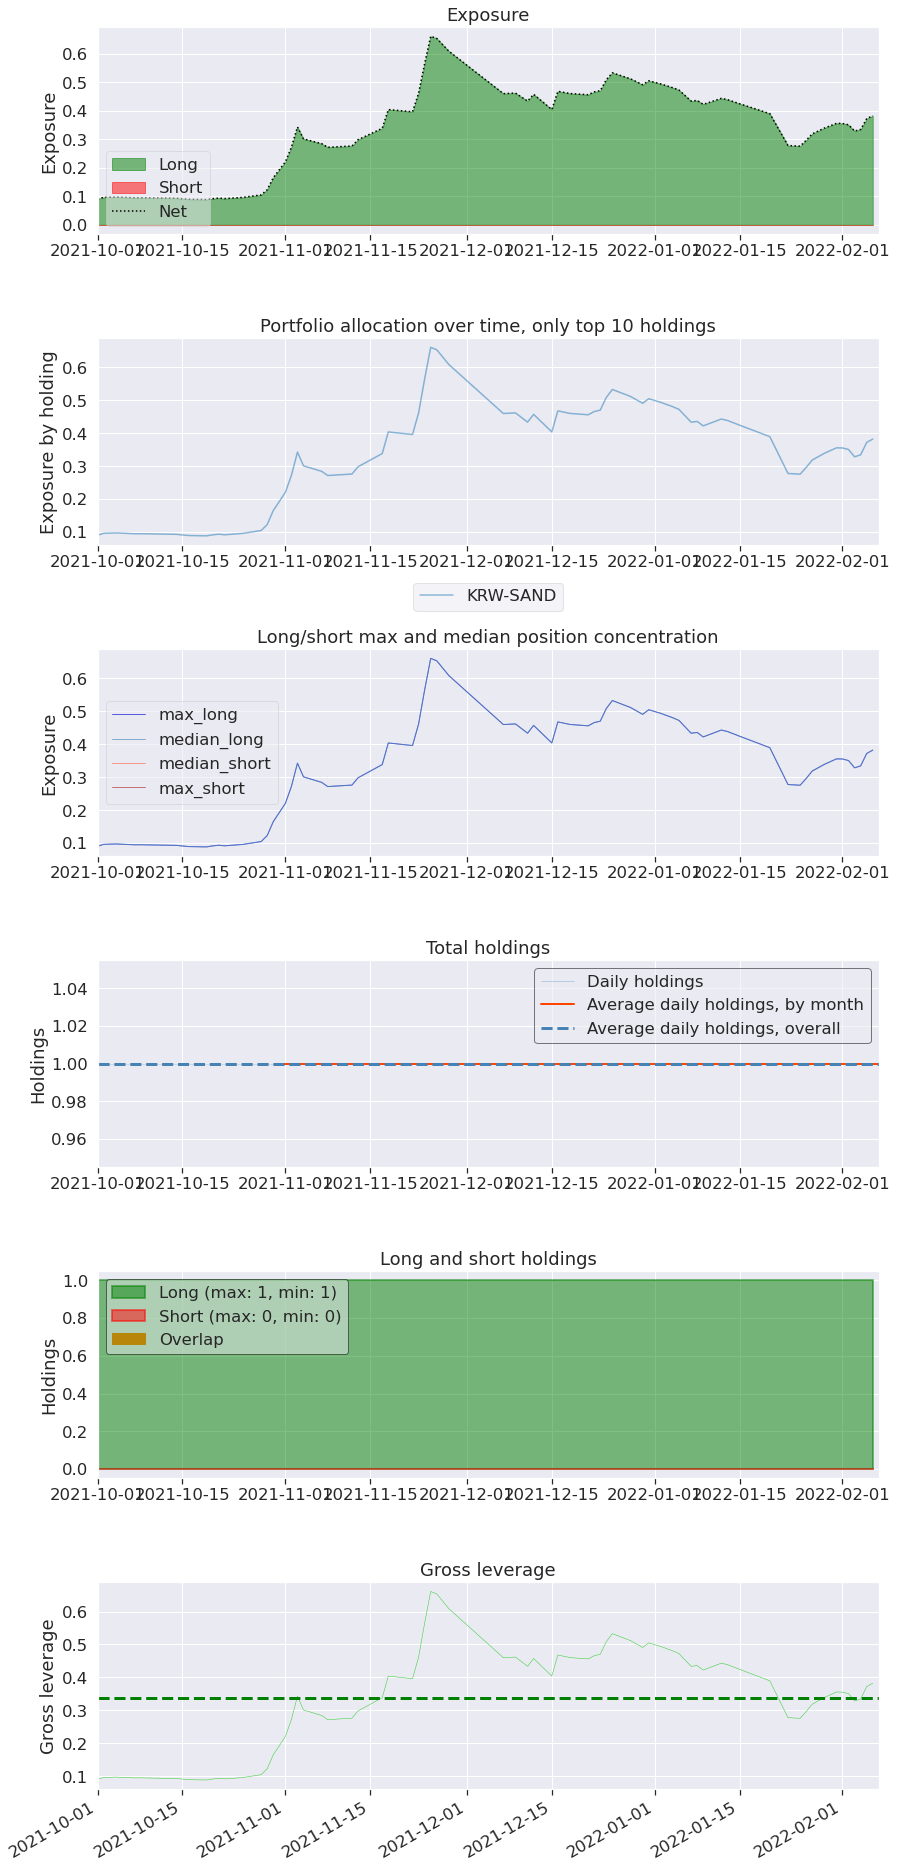

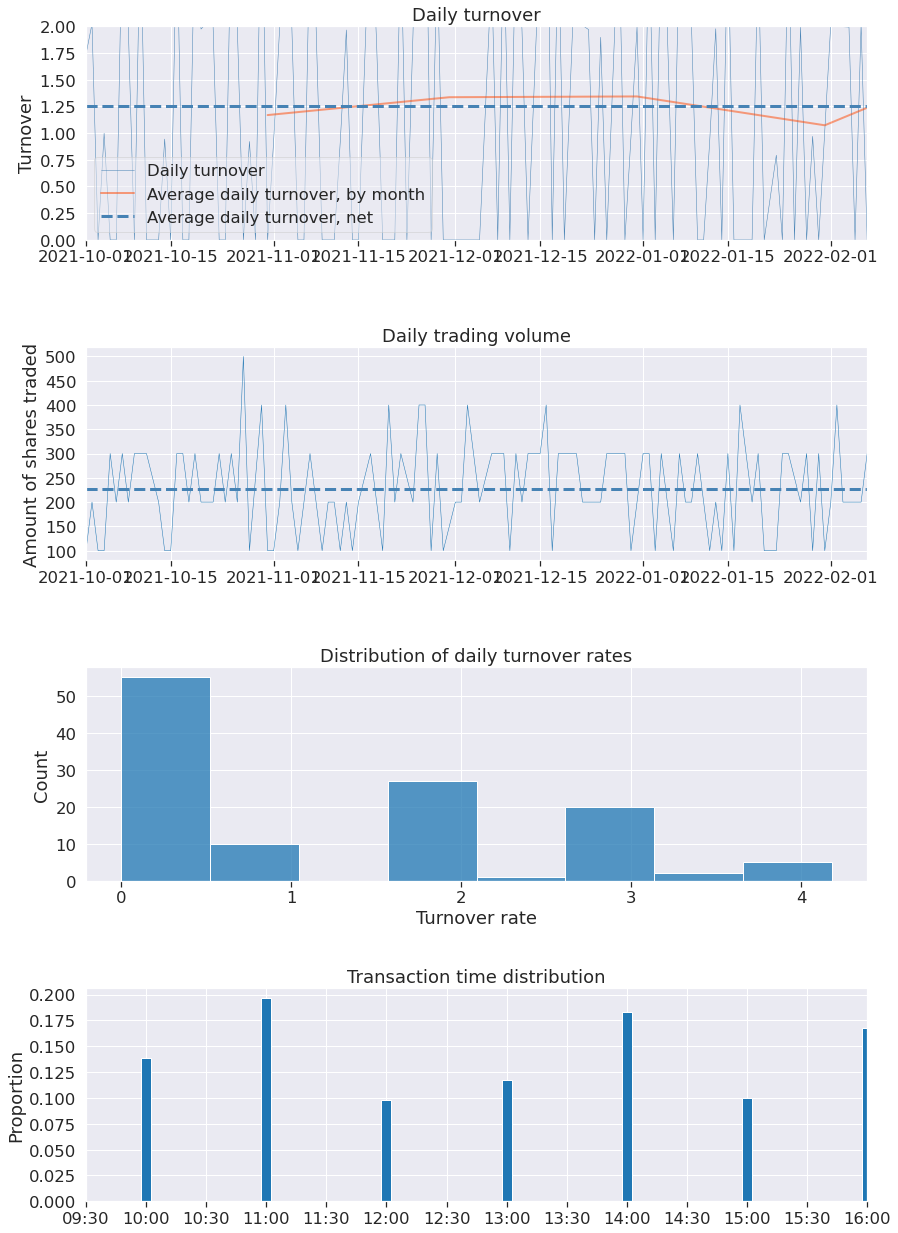

In [45]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_period_returns = results['benchmark_period_return']
daily_benchmark_returns = np.exp(np.log(benchmark_period_returns + 1.0).diff()) - 1
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)